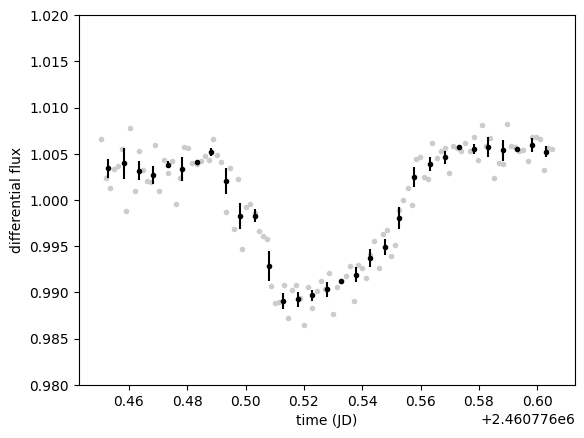

In [1]:
# import useful libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
from prose import Fluxes
from utils import transit_fit

# load data from pipeline
data = Fluxes.load("HPP-ETHZ_20250410_TrES-2b_G.flux")

# plot to be sure it's what we expect
ax = plt.subplot(xlabel="time (JD)", ylabel="differential flux", ylim=(0.98, 1.02))
data.plot()
data.bin(0.005, estimate_error=True).errorbar()


In [2]:
# get relevant data
df = data.df
df

,bkg,airmass,bjd,dx,dy,fwhm,time,flux
0,430.699611,1.966943,2.460776e+06,-2.877627,-0.378872,3.752980,2.460776e+06,1.006597
1,429.013106,1.951974,2.460776e+06,-2.232800,-0.568741,3.867267,2.460776e+06,1.002393
2,424.082414,1.937192,2.460776e+06,-2.384728,-0.585012,3.830452,2.460776e+06,1.001290
3,420.132704,1.922648,2.460776e+06,-3.358261,-0.957556,3.820240,2.460776e+06,1.003327
4,417.167967,1.908390,2.460776e+06,-4.744876,-1.632666,3.752689,2.460776e+06,1.003691
...,...,...,...,...,...,...,...,...
105,226.191676,1.134984,2.460777e+06,3.529760,0.163309,4.479027,2.460777e+06,1.006774
106,225.787393,1.131549,2.460777e+06,0.499109,0.445351,4.755998,2.460777e+06,1.006551
107,224.934517,1.128190,2.460777e+06,-6.228154,0.845056,4.754896,2.460777e+06,1.003195
108,224.401388,1.124858,2.460777e+06,-8.469615,0.767245,4.910025,2.460777e+06,1.005635


In [3]:
# normalise flux to 1 using ~pre-transit flux (first 10 data points)
df.flux = df.flux/np.mean(df.flux[:10])

In [4]:
# read known transit parameters from initial discovery
known_transits_params ="""
name,priority,dec_j2000,ra_j2000,v_mag,t0_bjd_tdb,t0_unc,period_days,period_unc,min_telescope_inches,depth_r_mmag,duration_hours,rp_over_rs,sma_over_rs,inclination,eccentricity,periastron
TrES-2b,low,+49:18:59.090,19:07:14.0379,11.25,2455706.8297691,4.1e-06,2.470613372,2.4e-08,5.0,14.29623492589524,1.79,0.1254,7.903,83.872,0.0,0.0
HAT-P-36b,low,+44:54:55.197,12:33:03.9061,12.15,2457885.383994,9.4e-05,1.327346813,9.7e-08,6.21,19.01868728712142,2.22,0.126,4.67,85.2,0.063,51.0
"""

df_params = pd.read_csv(StringIO(known_transits_params))
df_params

,name,priority,dec_j2000,ra_j2000,v_mag,t0_bjd_tdb,t0_unc,period_days,period_unc,min_telescope_inches,depth_r_mmag,duration_hours,rp_over_rs,sma_over_rs,inclination,eccentricity,periastron
0,TrES-2b,low,+49:18:59.090,19:07:14.0379,11.25,2.455707e+06,0.000004,2.470613,2.400000e-08,5.00,14.296235,1.79,0.1254,7.903,83.872,0.000,0.0
1,HAT-P-36b,low,+44:54:55.197,12:33:03.9061,12.15,2.457885e+06,0.000094,1.327347,9.700000e-08,6.21,19.018687,2.22,0.1260,4.670,85.200,0.063,51.0


TRANSIT FIT RESULTS

RMS residuals: 0.001867
Number of data points: 110

Initial parameter guesses:
      Mid-transit time (t0): 2460776.528409 BJD
                     Period: 2.470613 days
                       a/Rs: 7.903000
                      Rp/Rs: 0.125400
          Inclination (deg): 83.87°
                         u1: 0.400000
                         u2: 0.300000

Best-fit parameters:
      Mid-transit time (t0): 2460776.526707 ± 0.001074 BJD
                     Period: 2.481758 ± 361.349870 days
                       a/Rs: 7.766280 ± 1117.147816
                      Rp/Rs: 0.130070 ± 0.149711
          Inclination (deg): 83.73 ± 907.03°
                         u1: 0.655467 ± 20.394082
                         u2: 0.010048 ± 21.759649


/home/jovyan/utils.py:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=2)


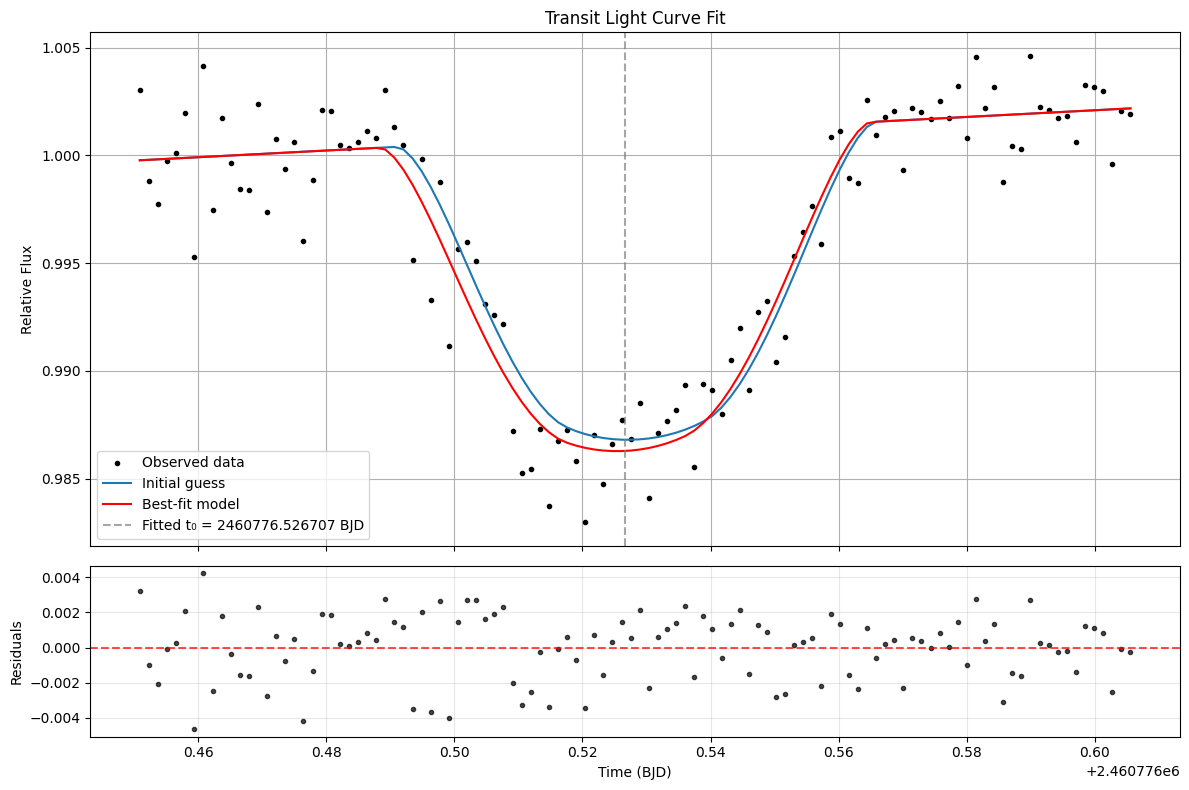

In [5]:
# fit transit

id = 0
_ = transit_fit(
    time = df.bjd.values, 
    flux = df.flux,
    duration_known = df_params.loc[id, 'duration_hours'] / 24,  # Convert hours to days
    period_known = df_params.loc[id, 'period_days'],
    transittime = df_params.loc[id, 't0_bjd_tdb'],
    a_guess = df_params.loc[id, 'sma_over_rs'],
    rp_guess = df_params.loc[id, 'rp_over_rs'],
    inc_guess = df_params.loc[id, 'inclination'],
    plot_results = True,
)